Imports

In [1]:
import feed_forward
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import geoopt
from time import time
from torchvision import datasets, transforms
import helper
torch.cuda.is_available()

True

CUDA check

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

Data Transformation

In [3]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)),
                              ])

Training and Test data from MNIST data set

In [4]:
trainset = datasets.MNIST('PATH_TO_STORE_TRAINSET', download=True, train=True, transform=transform)
n_inputs = 784
valset = datasets.MNIST('PATH_TO_STORE_TESTSET', download=True, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=512, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=512, shuffle=True)

C:\Users\julia\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Initializing the model

In [5]:
model = feed_forward.HypFF()
model.to(device)

HypFF(
  (fc1): MobLinear(
    in_features=784, out_features=512, bias=True
    (ball): PoincareBall manifold
  )
  (fc2): MobLinear(
    in_features=512, out_features=256, bias=True
    (ball): PoincareBall manifold
  )
  (fc3): MobLinear(
    in_features=256, out_features=10, bias=True
    (ball): PoincareBall manifold
  )
)

In [6]:
print(model)

HypFF(
  (fc1): MobLinear(
    in_features=784, out_features=512, bias=True
    (ball): PoincareBall manifold
  )
  (fc2): MobLinear(
    in_features=512, out_features=256, bias=True
    (ball): PoincareBall manifold
  )
  (fc3): MobLinear(
    in_features=256, out_features=10, bias=True
    (ball): PoincareBall manifold
  )
)


Hyperparameters

In [7]:
#learning_rate = 16e-4
learning_rate = 2e-1 #current learning rate for model without activation functions
momentum = 0.9

Loss Function

In [8]:
criterion = nn.CrossEntropyLoss()
images, labels = next(iter(trainloader))
images, labels = images.to(device), labels.to(device)
images = 0.0357*images.view(images.shape[0], -1)

out = model(images) #output
print(out)
loss = criterion(out, labels) #calculate the loss

tensor([[-0.3168, -0.3062, -0.3142,  ..., -0.3216, -0.3079, -0.3232],
        [-0.3172, -0.3067, -0.3143,  ..., -0.3220, -0.3067, -0.3224],
        [-0.3169, -0.3064, -0.3147,  ..., -0.3216, -0.3077, -0.3230],
        ...,
        [-0.3178, -0.3064, -0.3144,  ..., -0.3216, -0.3068, -0.3223],
        [-0.3176, -0.3066, -0.3139,  ..., -0.3218, -0.3070, -0.3221],
        [-0.3182, -0.3069, -0.3145,  ..., -0.3206, -0.3077, -0.3218]],
       device='cuda:0', grad_fn=<SWhereBackward>)


Optimizer

In [9]:
optimizer = geoopt.optim.RiemannianSGD(model.parameters(), lr=learning_rate, momentum=momentum)

In [10]:

time0 = time()

epochs = 15
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        # Flatten MNIST images into a 784 long vector
        images = 0.0357*images.view(images.shape[0], -1)
    
        # Training pass
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        
        #backpropagation
        loss.backward()
        
        #Weight optimization
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
print("\nTraining Time (in minutes) =",(time()-time0)/60)

Epoch 0 - Training loss: 2.2727401014101707
Epoch 1 - Training loss: 2.120354413986206
Epoch 2 - Training loss: 2.0765020281581554
Epoch 3 - Training loss: 2.059266195458881
Epoch 4 - Training loss: 2.05212875341965
Epoch 5 - Training loss: 2.04829455028146
Epoch 6 - Training loss: 2.04579631756928
Epoch 7 - Training loss: 2.0440651966353593
Epoch 8 - Training loss: 2.0425222021038247
Epoch 9 - Training loss: 2.0414136951252564
Epoch 10 - Training loss: 2.0405008772672235
Epoch 11 - Training loss: 2.039683014659558
Epoch 12 - Training loss: 2.0390893806845454
Epoch 13 - Training loss: 2.0385063785617636
Epoch 14 - Training loss: 2.038094476117926

Training Time (in minutes) = 4.705999251206716


Predicted Digit = 6


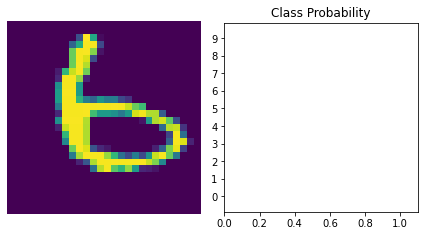

In [26]:
images, labels = next(iter(valloader))
#images, labels = images.to(device), labels.to(device)

img = 0.0357*images[0].view(1, 784)
img_gpu = img.to(device)
with torch.no_grad():
    out = model(img_gpu)

ps = out.cpu()
probab = list(ps.numpy()[0])
print("Predicted Digit =", probab.index(max(probab)))
helper.view_classify(img.view(1, 28, 28), ps)

In [12]:
correct_count, all_count = 0, 0
for images,labels in valloader:
  images, labels = images.to(device), labels.to(device)
  for i in range(len(labels)):
    img = 0.0357*images[i].view(1, 784)
    with torch.no_grad():
        out = model(img)

    
    ps = out.cpu()
    probab = list(ps.numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.cpu().numpy()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 10000

Model Accuracy = 0.977


Current status of experiments:
1. Using just Hyperboic Linear modules, and with the appropriate self-tuned hyperparameters, and a batch size of 512, the average accuracy converged around 90 percent
2. With the use of activation functions(ReLu, ReLu, then LogSoftMax at the output layer), (by applying the functions in the tangent space, then mapping it nack to the hyperbolic space), we see an increase in the model accuracy to about 97.7 percent.
3. 